# Taxi Orders Prediction - Time Series Forecasting - Sweet Lift Taxi Company

Introduction

## Data Preprocessing

In [17]:
# Load packages
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [18]:
# load dataset
try:
    df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except Exception:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [19]:
# set global constants and settings
sns.set_style('darkgrid')

In [20]:
# take a look at the data
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [22]:
print(f'Data in chronological order: {df.index.is_monotonic_increasing}')

Data in chronological order: True


<Axes: xlabel='datetime'>

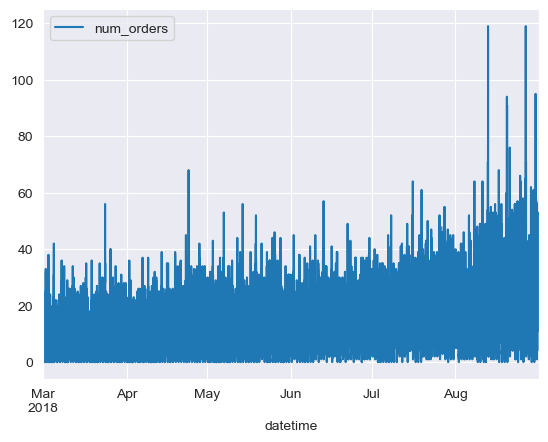

In [23]:
df.plot()

<Axes: xlabel='datetime'>

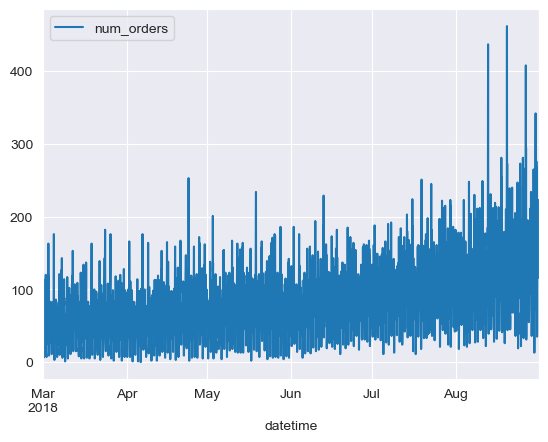

In [24]:
df = df.resample('1H').sum()
df.plot()

In [25]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


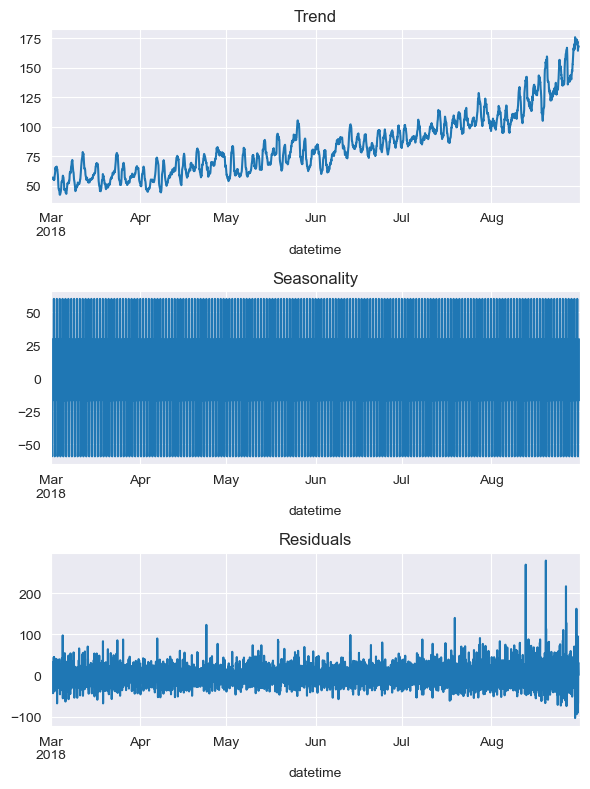

In [26]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<Axes: xlabel='datetime'>

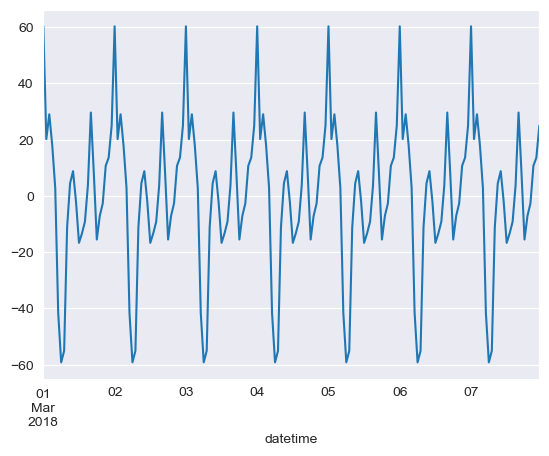

In [27]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [29]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [30]:
make_features(df, 24, 14)
display(df)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,148.142857
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,152.285714
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,160.785714


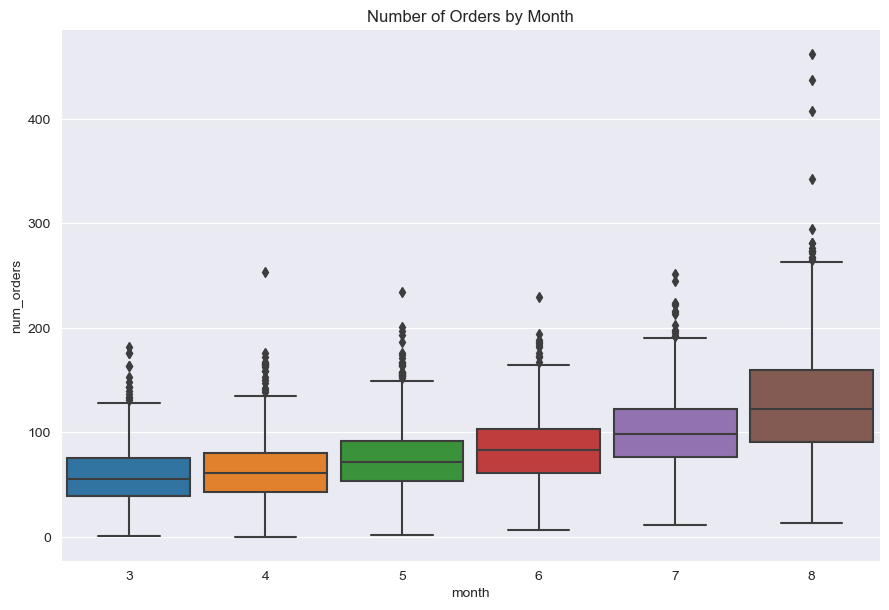

In [35]:
sns.catplot(x="month", y="num_orders", kind="box", data=df, width=0.9, height=6, aspect=1.5)
plt.title("Number of Orders by Month")
plt.show()

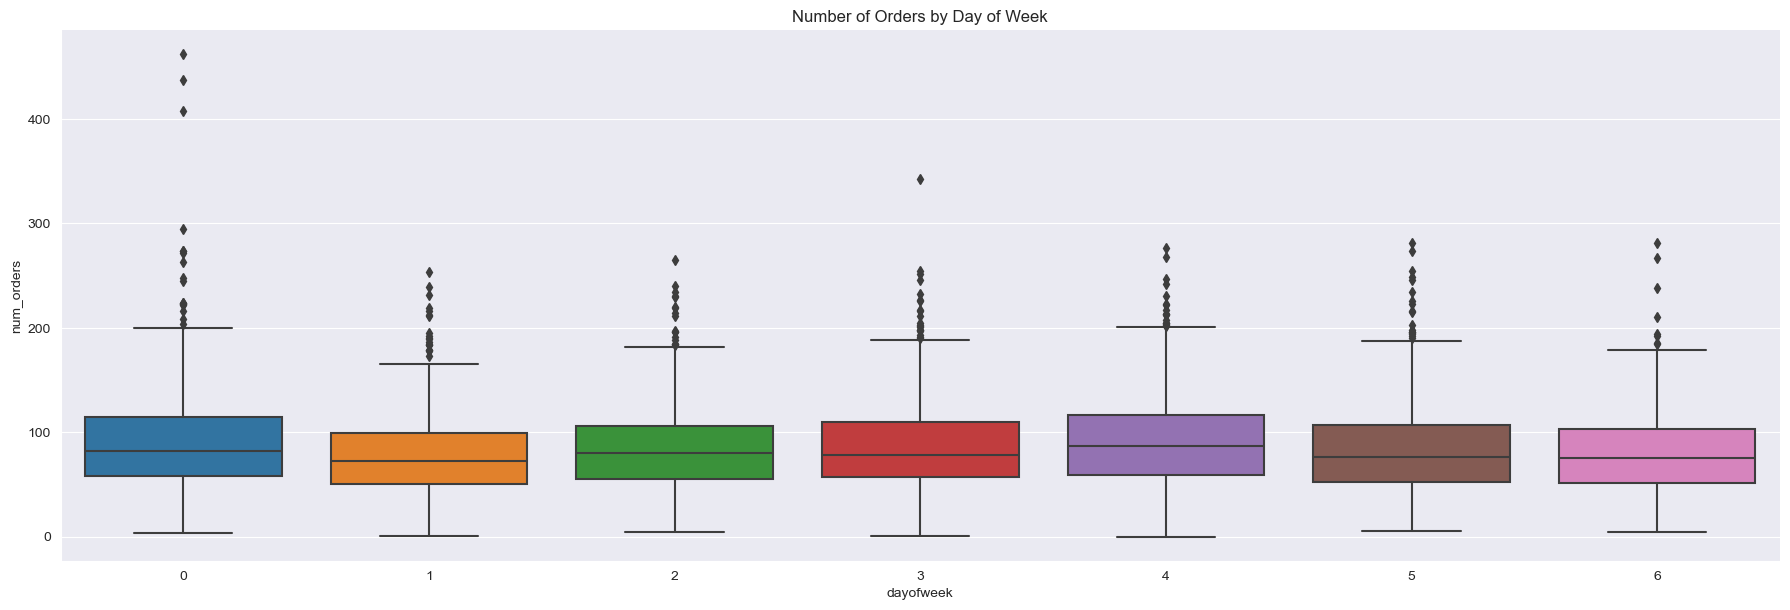

In [38]:
sns.catplot(x="dayofweek", y="num_orders", kind="box", data=df, width=0.8, height=6, aspect=3)
plt.title("Number of Orders by Day of Week")
plt.show()

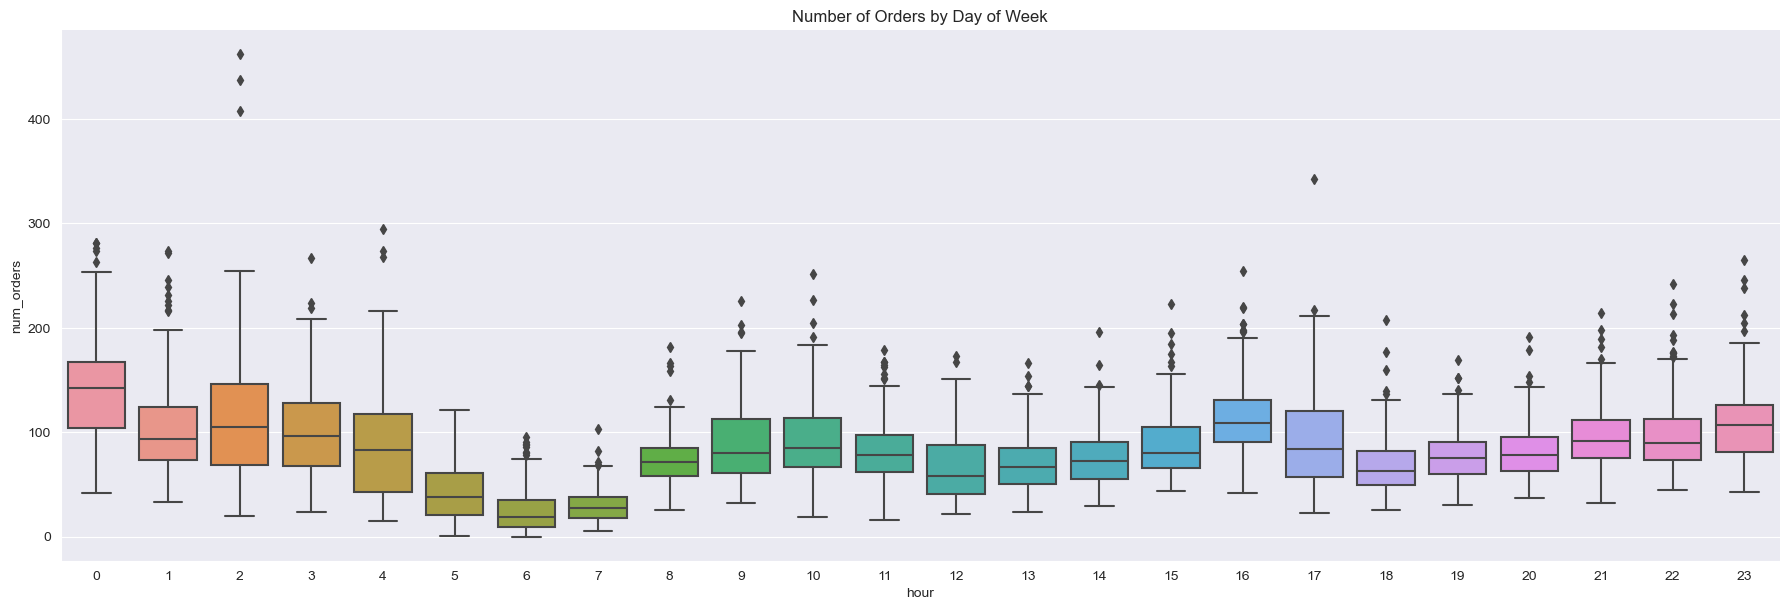

In [39]:
sns.catplot(x="hour", y="num_orders", kind="box", data=df, width=0.8, height=6, aspect=3)
plt.title("Number of Orders by Day of Week")
plt.show()